<a href="https://colab.research.google.com/github/du-hr/covid-atals/blob/main/MiniProject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID Atalas: Analyzing COVID-19 Search Trends and Hospitalization with ML


> MiniProject 1 of COMP 551 (Fall 2020) at McGill University


> Authors (G68): Haoran Du, Cong Zhu, Matthew Kourlas





In [140]:
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

## Task 1: Acquire, preprocess, and analyze the data.

### 1.1 Download the datasets. Load the datasets into Pandas dataframes or NumPy objects (i.e., arrays or matrices) in Python.

In [141]:

url_search = "https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv"
url_hospital = "https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv"

df_search = pd.read_csv(url_search, low_memory=False)
df_hospital = pd.read_csv(url_hospital, low_memory=False)

pd.set_option('display.max_columns', None)


###1.2 Clean the data. Remove regions and features that have too many missing or invalid data entries.

In [142]:
print("Length of search dataset before cleaning = " + str(len(df_search)))
df_search.dropna(thresh=8, inplace=True)
df_search.dropna(axis=1, how="all", inplace=True)
print("Length of search dataset after cleaning = " + str(len(df_search)))

print("\nLength of hospital dataset before cleaning = " + str(len(df_hospital)))

df_hospital = df_hospital[ (df_hospital["open_covid_region_code"] >= "US-A") & (df_hospital["open_covid_region_code"] <= "US-Z") ]
df_hospital.dropna(axis=1, how="all", inplace=True)
print("Length of hospital dataset after cleaning = " + str(len(df_hospital)))

Length of search dataset before cleaning = 640
Length of search dataset after cleaning = 599

Length of hospital dataset before cleaning = 102912
Length of hospital dataset after cleaning = 12821


###1.3 Merge the two datasets. Bring both the datasets at the weekly resolution and thereafter merge them into one array (Numpy or Pandas).

In [143]:



df_search["date"] = pd.to_datetime(df_search["date"])

df_hospital["date"] = pd.to_datetime(df_hospital["date"])

df_search = df_search.set_index(["date"])
df_search = df_search.shift(periods=6, freq="D")
df_hospital = df_hospital.set_index(["date"])


grouper = df_hospital.groupby([pd.Grouper(freq='1W'), 'open_covid_region_code'])
df_hospital = grouper['hospitalized_new', 'hospitalized_cumulative'].sum()

df_search = df_search.groupby(by=["date", "open_covid_region_code"]).sum()

df_hospital = df_hospital.drop(["2020-10-11", "2020-10-04"])
df_search = df_search.drop(["2020-01-12", "2020-01-19"])

df = pd.concat([df_hospital, df_search], axis=1, sort=False)

df.dropna(thresh=122, inplace=True)

# print(df)
# from google.colab import files

# df.to_csv('df.csv')
# files.download('df.csv')





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


## Task 2: Visualize and cluster the data

### 2.1 Visualize how the distribution of search frequency of each symptom aggregated across different regions changes over time.

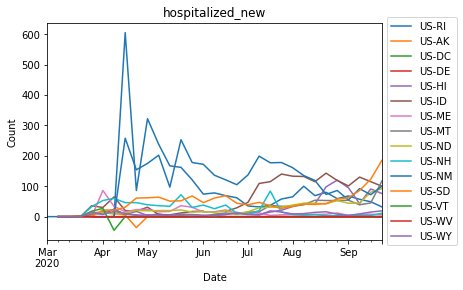

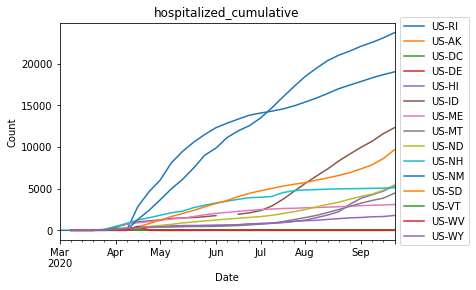

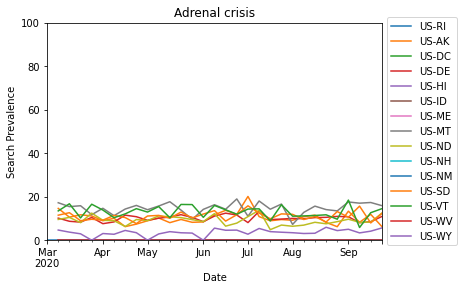

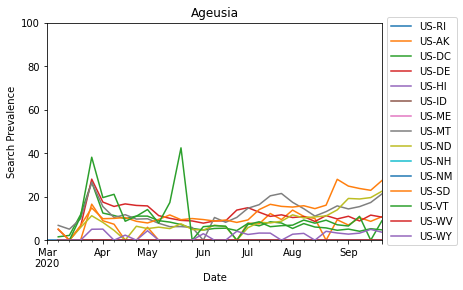

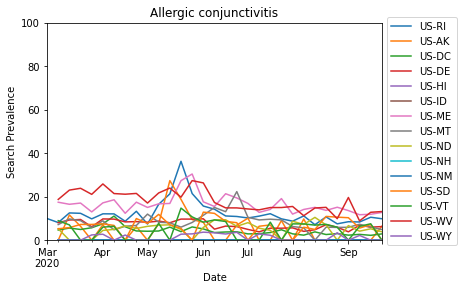

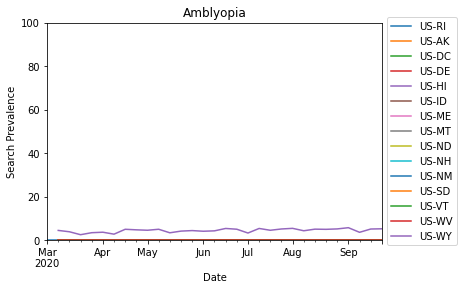

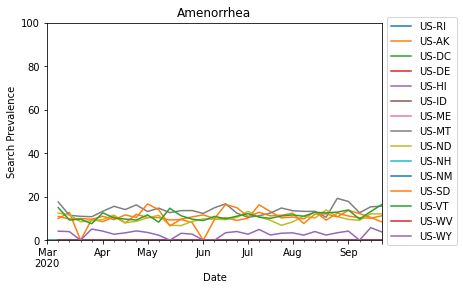

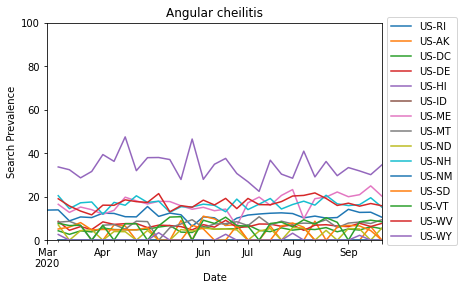

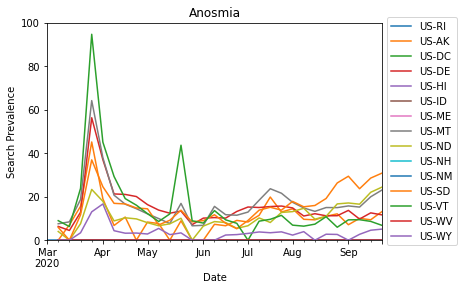

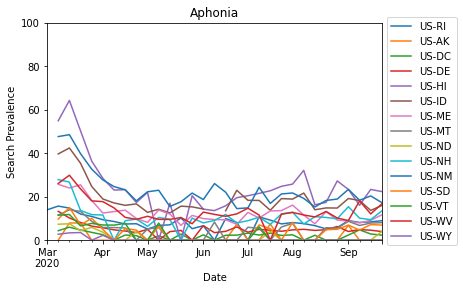

--- Full list of symptoms ---
symptom:Adrenal crisis
symptom:Ageusia
symptom:Allergic conjunctivitis
symptom:Amblyopia
symptom:Amenorrhea
symptom:Angular cheilitis
symptom:Anosmia
symptom:Aphonia


In [144]:
# Current visualization strategy: plot features over time (symptom/hospitalization stat) separately from
# each other, but aggregating all regions for each feature

# Choose set of symptoms to plot (ex. symptoms = ['symptom:Balance disorder', 'symptom:Rheum'])
# Graphing all symptoms for now, takes several minutes
symptoms = [symptom for symptom in df.columns.values if symptom.startswith('symptom')][:8]

unstacked = df.unstack(level=[1])

# Generate hospitalization plots (not required by project, just for our benefit)
for stat in {'hospitalized_new', 'hospitalized_cumulative'}:
    p = unstacked[stat].plot()
    p.set_title(stat)
    p.set_xlabel("Date")
    p.set_ylabel("Count")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Generate symptom plots
for symptom in symptoms:
    p = unstacked[symptom].plot()
    p.set_title(symptom[8:])  # remove 'symptom:' prefix
    p.set_xlabel("Date")
    p.set_ylabel("Search Prevalence")
    plt.ylim((0,100)) # search prevalence ranges from 0 to 100
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

# Print full list of symptoms    
print("--- Full list of symptoms ---")
for symptom in symptoms:
    print(symptom)

###2.2 Visualize the search trends dataset in a lower dimensional space.

     principal component 1  principal component 2  hospitalized_new
0                -5.697338              -3.119986               0.0
1                14.212675               6.554208               0.0
2                -5.002889               0.032335               0.0
3                 1.098805              -4.856952               0.0
4                -7.517163               0.937703               0.0
..                     ...                    ...               ...
445              -5.682768              -2.891729              32.0
446              10.186469              -3.745095             185.0
447              15.263355               0.451908               0.0
448              -6.834679              -4.343307               0.0
449               0.190533               8.272682              19.0

[450 rows x 3 columns]


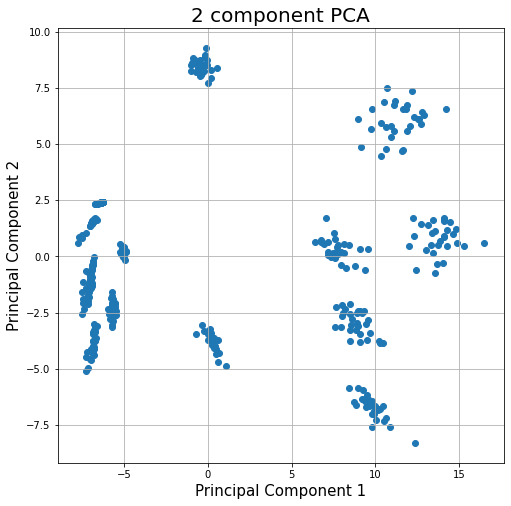

In [145]:
from sklearn.preprocessing import StandardScaler
features = [symptom for symptom in df.columns.values if symptom.startswith('symptom')]
# Separating out the features
x = df.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Projection to 1 PC
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# reduced dataframe
df_copy = df.reset_index()
df_reduced = pd.concat([principalDf, df_copy[['hospitalized_new']]], axis = 1)
print(df_reduced)

# Visualize 2D Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(df_reduced['principal component 1'], df_reduced['principal component 2'])
ax.grid()


###2.3 Explore using a clustering method (k-means) to evaluate possible groups in the search trends dataset. Do the clusters remain consistent for raw as well as PCA-reduced data?

For 1 clusters:
Raw cost: 2074362.9427333334
PCA cost: 33195.24519051165
Adjusted Rand Index: 1.0


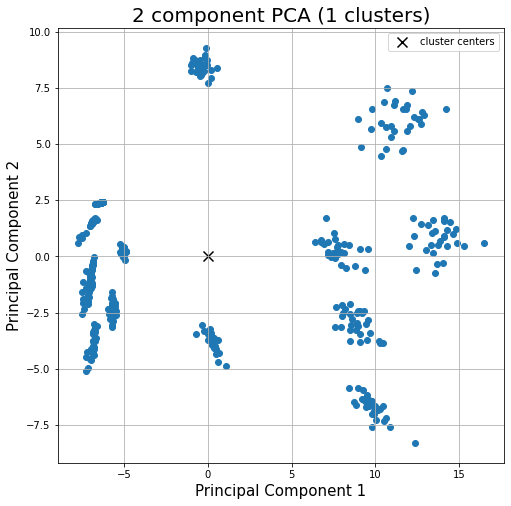

For 2 clusters:
Raw cost: 1285085.3646689998
PCA cost: 9278.535381659389
Adjusted Rand Index: 1.0


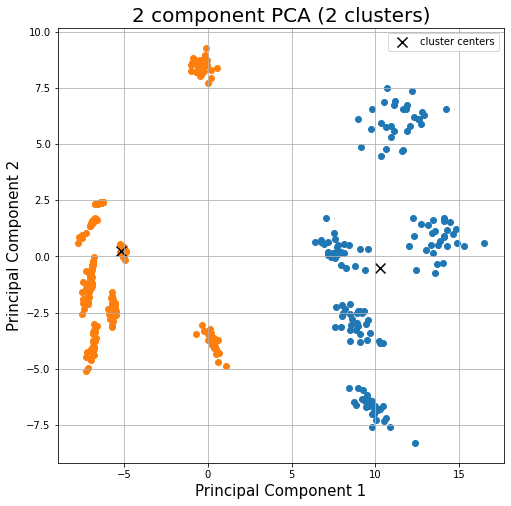

For 3 clusters:
Raw cost: 1086772.676532935
PCA cost: 6280.056084233187
Adjusted Rand Index: 0.5477516391775542


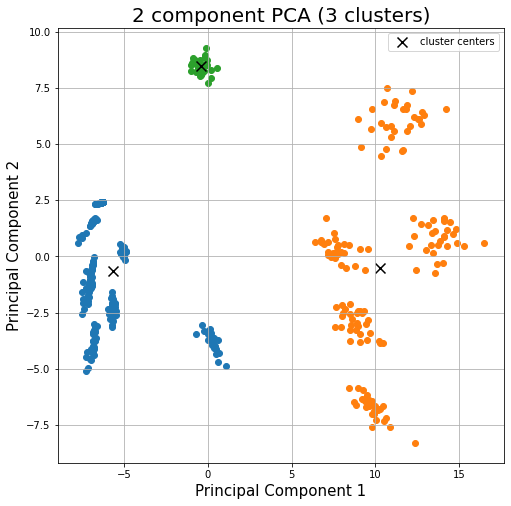

For 4 clusters:
Raw cost: 980409.0118369348
PCA cost: 4228.357012955545
Adjusted Rand Index: 0.4430063447733333


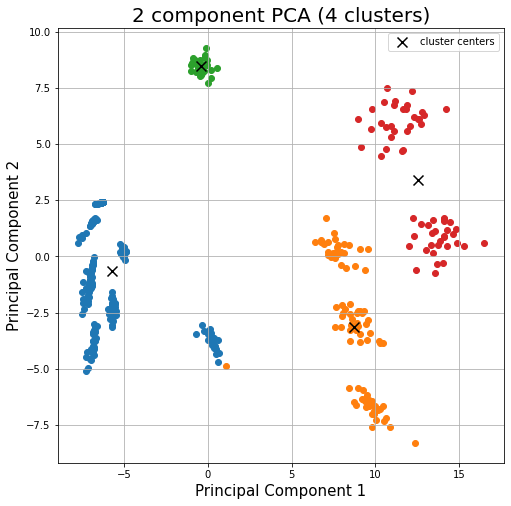

For 5 clusters:
Raw cost: 868956.5251381809
PCA cost: 2728.4142901627793
Adjusted Rand Index: 0.3564256630107729


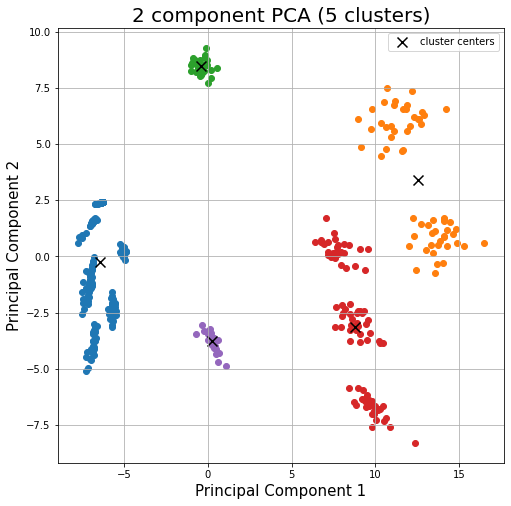

For 6 clusters:
Raw cost: 780747.7742044905
PCA cost: 1879.2791373809175
Adjusted Rand Index: 0.6925090113784138


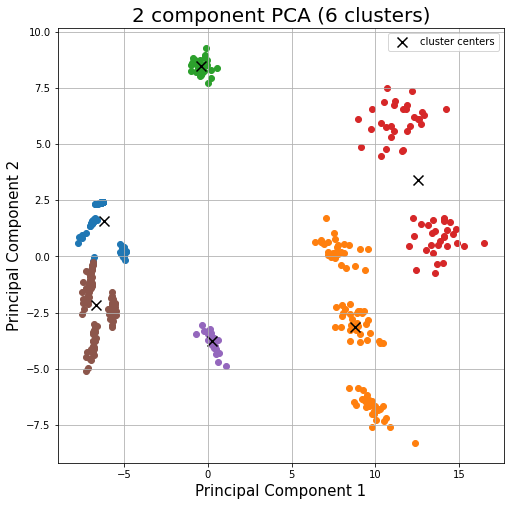

For 7 clusters:
Raw cost: 741605.3836120607
PCA cost: 1244.5887758039241
Adjusted Rand Index: 0.792368353444066


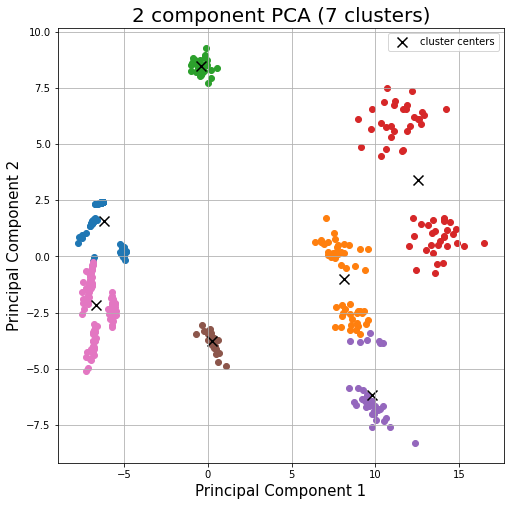

For 8 clusters:
Raw cost: 676291.4034052939
PCA cost: 746.7657848804545
Adjusted Rand Index: 0.5978277396063187


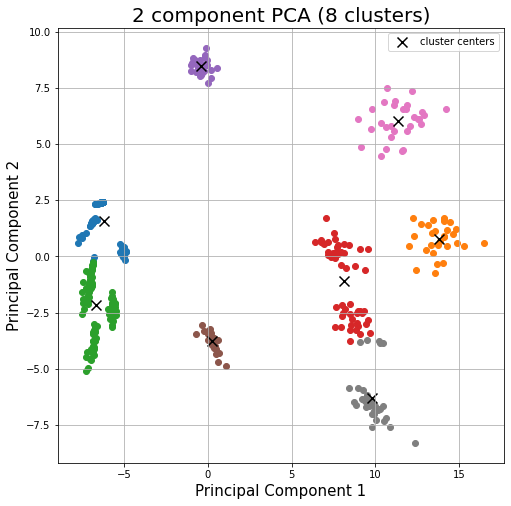

For 9 clusters:
Raw cost: 639056.0309812749
PCA cost: 576.6077144422854
Adjusted Rand Index: 0.5432014679034182


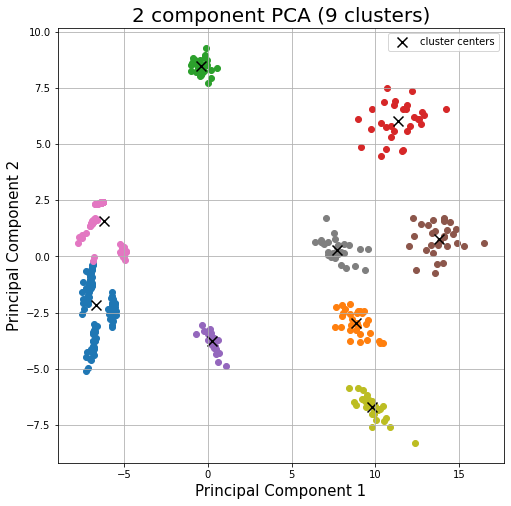

For 10 clusters:
Raw cost: 581624.4485343146
PCA cost: 420.2360393255042
Adjusted Rand Index: 0.5221266224997808


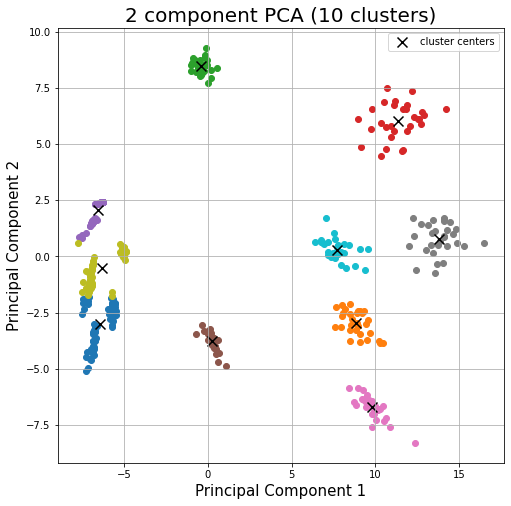

For 11 clusters:
Raw cost: 550145.2258564954
PCA cost: 310.95974451534056
Adjusted Rand Index: 0.7444444824468276


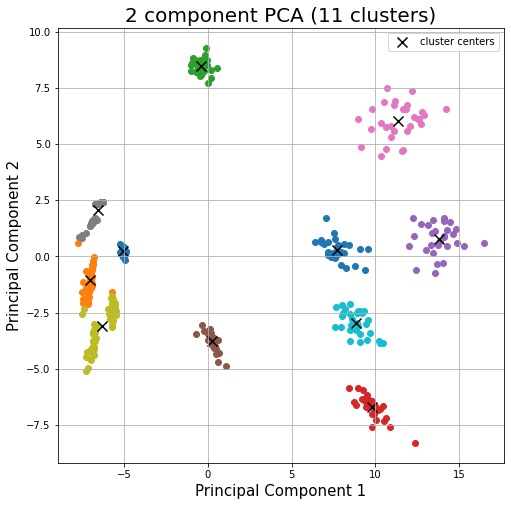

For 12 clusters:
Raw cost: 522664.92007164186
PCA cost: 251.7343514579689
Adjusted Rand Index: 0.7722927827158993


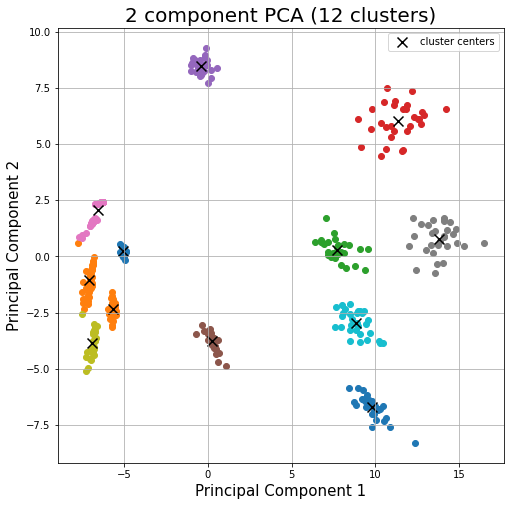

For 13 clusters:
Raw cost: 472768.7269763814
PCA cost: 223.1699433610779
Adjusted Rand Index: 0.6943049762724133


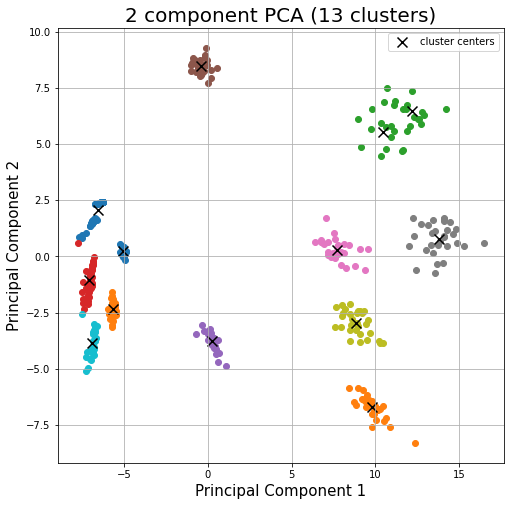

For 14 clusters:
Raw cost: 443809.3762012925
PCA cost: 208.4273240102497
Adjusted Rand Index: 0.7449590023820322


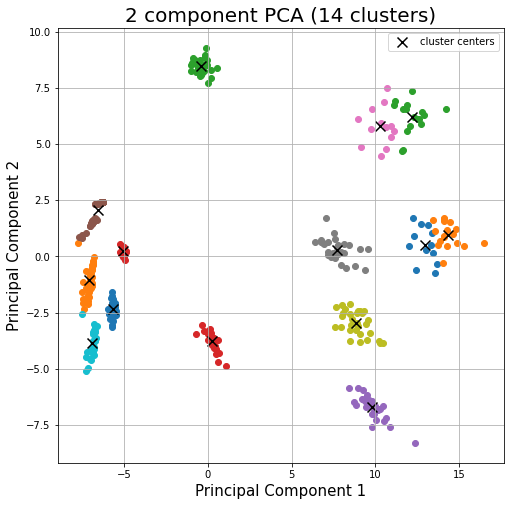

For 15 clusters:
Raw cost: 417578.9969021386
PCA cost: 185.67068993382864
Adjusted Rand Index: 0.8039100272820084


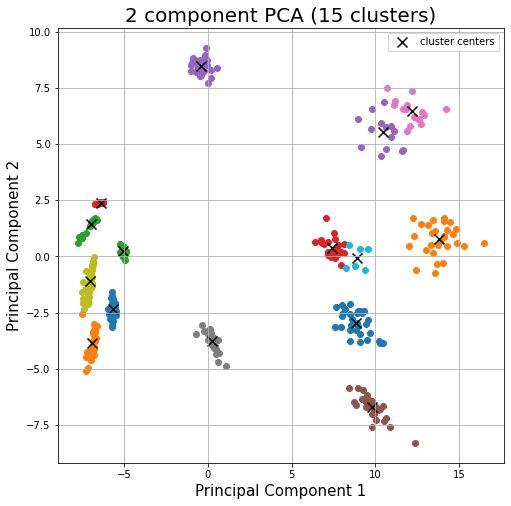

For 16 clusters:
Raw cost: 383996.6808581158
PCA cost: 169.71261830353035
Adjusted Rand Index: 0.7715167531107247


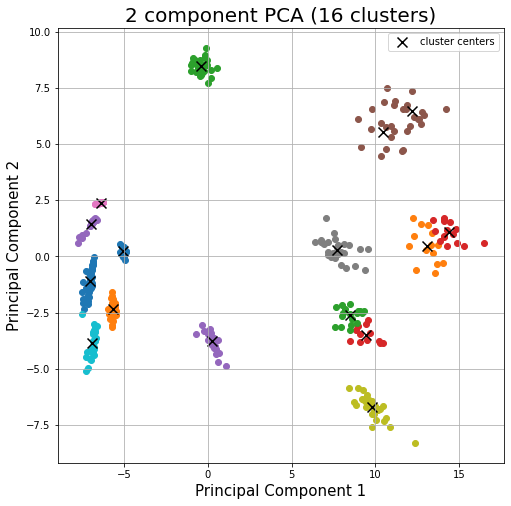

For 17 clusters:
Raw cost: 359232.4669724287
PCA cost: 160.92282199566344
Adjusted Rand Index: 0.8107346219634465


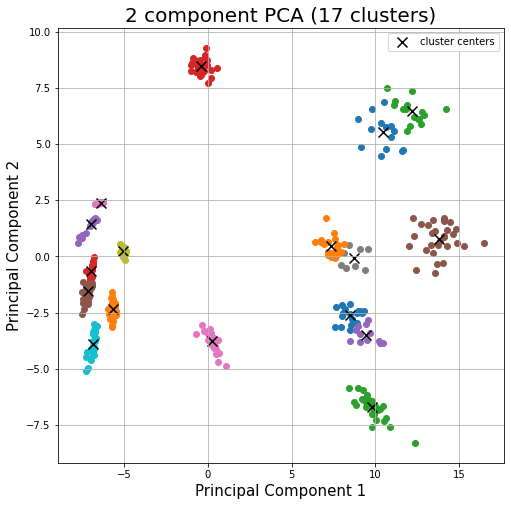

For 18 clusters:
Raw cost: 339190.8781233826
PCA cost: 144.69918225323846
Adjusted Rand Index: 0.7998182217562563


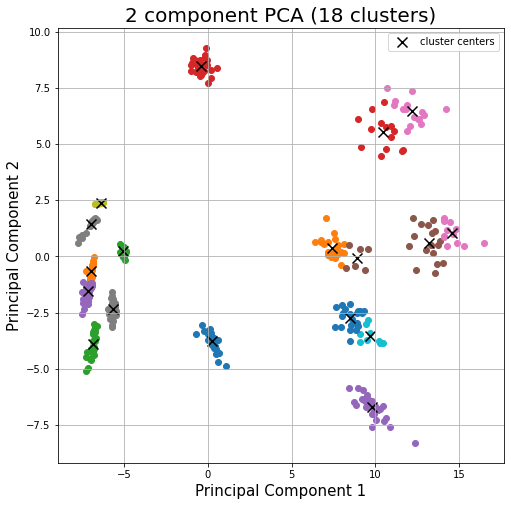

For 19 clusters:
Raw cost: 329955.4596916065
PCA cost: 137.60945511702755
Adjusted Rand Index: 0.8391409918050544


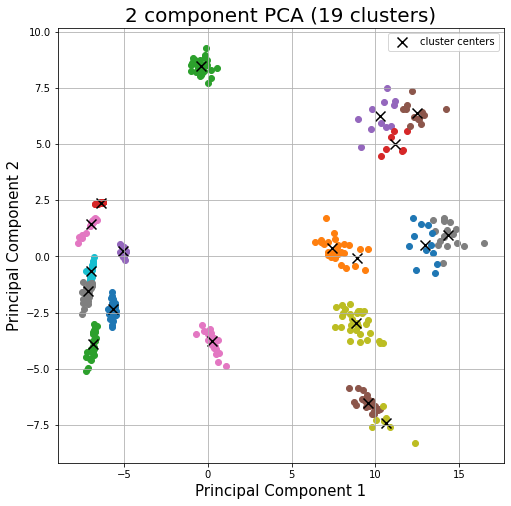

For 20 clusters:
Raw cost: 315588.88689705683
PCA cost: 124.94401595043328
Adjusted Rand Index: 0.813198612574138


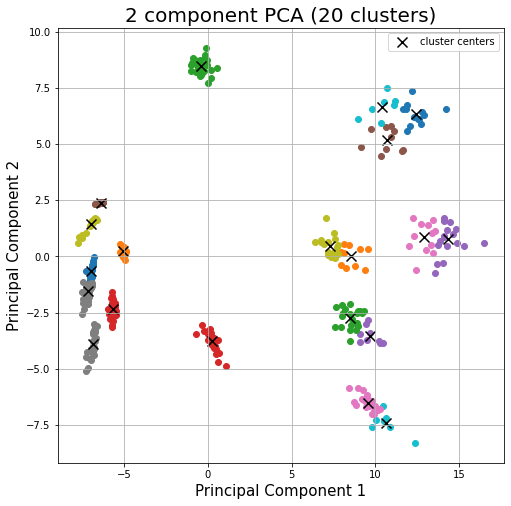

In [146]:
# explore K-means clustering with k = [0,20]
for k in range(1, 21):
  # raw data
  cluster_raw = df.loc[:, features]
  kmeans_raw = KMeans(n_clusters=k).fit(cluster_raw)
  cluster_raw['cluster'] = kmeans_raw.labels_
  cluster_raw.set_index('cluster', inplace=True, append=True)

  # pca-reduced data
  cluster_pca = df_reduced.drop(columns=['hospitalized_new'])
  kmeans_pca = KMeans(n_clusters=k).fit(cluster_pca)
  cluster_pca['cluster'] = kmeans_pca.labels_
  cluster_pca.set_index('cluster', inplace=True, append=True)

  # compare clustering between raw and pca using adjusted rand score
  score = adjusted_rand_score(kmeans_raw.labels_, kmeans_pca.labels_)

  print("For", k, "clusters:")
  print("Raw cost:", kmeans_raw.inertia_)
  print("PCA cost:", kmeans_pca.inertia_)
  print("Adjusted Rand Index:", score)

  # plot clustering of pca reduced data
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA (' + str(k) + ' clusters)', fontsize = 20)
  ax.grid()
  for i in range(k):
      series = cluster_pca.query('cluster==' + str(i))
      ax.scatter(series['principal component 1'], series['principal component 2'])
  ax.scatter(kmeans_pca.cluster_centers_[:, 0],
             kmeans_pca.cluster_centers_[:, 1],
             marker='x', s=100, facecolor='black', label='cluster centers')
  ax.legend()
  plt.show()


## Task 3: Supervised Learning

###3.1 Split the data (region): keep all data from some regions in the validation set and train on the rest (keep 80% regions in training set and 20% in validation set, doing this multiple times to estimate cross-validation results).

In [147]:
df_copy = df
df = df.reset_index()
df['date'] = df['date'] - df['date'][0]
for i in range(len(df)):
  df['date'][i] = df['date'][i].days

test = df[(df["open_covid_region_code"] == "US-RI") | (df["open_covid_region_code"] == "US-AK")]
train = df[(df["open_covid_region_code"] != "US-RI") & (df["open_covid_region_code"] != "US-AK")]

x_train = train.drop(['hospitalized_new', 'hospitalized_cumulative', 'open_covid_region_code'], axis=1)
y_train = train[['hospitalized_new', 'hospitalized_cumulative']]

x_test = test.drop(['hospitalized_new', 'hospitalized_cumulative', 'open_covid_region_code'], axis=1)
y_test = test[['hospitalized_new', 'hospitalized_cumulative']]

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


###3.2 Split the data (time): keep data for the last couple of timepoints (keep data after `2020-08-10') from all regions in the validation set and train on the rest of the data.

In [148]:
# Select date to split data (training data will have dates up to and including split date)
split_date = np.datetime64('2020-08-09')

# Raw Data

# Drop region index
df_dates = df_copy.reset_index(level='open_covid_region_code', drop=True)

# Split dataframe into training and validation sets
# Use .to_numpy() to get sdarray
dates_train = df_dates[df_dates.index <= split_date]
dates_train_x = dates_train.drop(columns=['hospitalized_new', 'hospitalized_cumulative']).to_numpy()
dates_train_y = dates_train[:]['hospitalized_new'].to_numpy()

dates_val = df_dates[df_dates.index > split_date]
dates_val_x = dates_val.drop(columns=['hospitalized_new', 'hospitalized_cumulative']).to_numpy()
dates_val_y = dates_val[:]['hospitalized_new'].to_numpy()

# PCA reduced Data
r_dates_train = df_reduced[df_dates.index <= split_date]
r_dates_train_x = r_dates_train.drop(columns=['hospitalized_new']).to_numpy()
r_dates_train_y = dates_train_y

r_dates_val = df_reduced[df_dates.index > split_date]
r_dates_val_x = r_dates_val.drop(columns=['hospitalized_new']).to_numpy()

### 3.3 Supervised Learning: KNN (region) (5-fold cross-validation)

In [149]:
rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    error = math.sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 6208.453420043712
RMSE value for k=  2 is: 6207.855959898913
RMSE value for k=  3 is: 6208.697929955044
RMSE value for k=  4 is: 6208.386702043507
RMSE value for k=  5 is: 6208.895478633068
RMSE value for k=  6 is: 6208.708551411164
RMSE value for k=  7 is: 6208.545654353201
RMSE value for k=  8 is: 6208.307732713702
RMSE value for k=  9 is: 6208.598113455725
RMSE value for k=  10 is: 6208.419616781132
RMSE value for k=  11 is: 6208.296697383225
RMSE value for k=  12 is: 6208.338569211494
RMSE value for k=  13 is: 6208.445911181723
RMSE value for k=  14 is: 6208.42064298381
RMSE value for k=  15 is: 6208.122817197336
RMSE value for k=  16 is: 6208.188175698667
RMSE value for k=  17 is: 6208.477031170447
RMSE value for k=  18 is: 6208.557004149233
RMSE value for k=  19 is: 6209.039202892446
RMSE value for k=  20 is: 6209.369462844562


###3.4 Supervised Learning: KNN (time)

In [150]:
rmse_val = []
for i in range(1, 101):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)
    model.fit(dates_train_x, dates_train_y)
    pred = model.predict(dates_val_x)
    error = math.sqrt(mean_squared_error(dates_val_y, pred))
    rmse_val.append(error)
    print("RMSE value for k=", k, " is: ", error)

RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value for k= 20  is:  36.97974799677199
RMSE value

###3.5 Supervised Learning: Decision Tree (region) (5-fold cross-validation)

In [151]:
from sklearn import tree
model = tree.DecisionTreeClassifier()

# K-fold Cross-Validation， k = 5
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x_train, y_train['hospitalized_new'], scoring='accuracy', cv=kf)
# report performance
from numpy import mean
from numpy import std
print("hospitalized_new: " + str(mean(scores)))

scores = cross_val_score(model, x_train, y_train['hospitalized_cumulative'], scoring='accuracy', cv=kf)
print("hospitalized_cumulative: "+ str(mean(scores)))

hospitalized_new: 0.31118881118881114
hospitalized_cumulative: 0.28025308025308027


###3.6 Supervised Learning: Decision Tree (time)

In [152]:
model.fit(dates_train_x,dates_train_y)
model.score(dates_val_x,dates_val_y)

0.3047619047619048

### 3.7 **(Optional)** Explore other prediction strategies. For example, one strategy could be to learn separate models for predicting hospitalization in each region or cluster from Task 2.